In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [4]:
%load_ext autoreload
%autoreload 2

In [25]:
import neptune
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [16]:
use_neptune = False

In [469]:
generator_layers = 4
data_bus_size = 5
generator_bath_size = 1

In [470]:
real_phase = True
generic_generator = True
zxz = False
all_gates_parametrized = False

In [471]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [472]:
builder = PhaseCircuitBuilder(all_gates_parametrized=False)
real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)

In [473]:
pauli_strings, qubit_to_string_index = quwgans_circuits.get_discriminator(real)

In [474]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [475]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                         │
(0, 1): ───────X───Z───Ry(theta_r)───H───X───H───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                               │                                       │
(0, 2): ─────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                               │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                               │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [476]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───Rx(g0)───Rz(g5)───ZZ────────────────Rx(g14)───Rz(g19)───ZZ────────────────Rx(g28)───Rz(g33)───ZZ────────────────Rx(g42)───Rz(g47)───ZZ────────────────
                             │                                     │                                     │                                     │
(0, 1): ───Rx(g1)───Rz(g6)───ZZ^g10───ZZ───────Rx(g15)───Rz(g20)───ZZ^g24───ZZ───────Rx(g29)───Rz(g34)───ZZ^g38───ZZ───────Rx(g43)───Rz(g48)───ZZ^g52───ZZ───────
                                      │                                     │                                     │                                     │
(0, 2): ───Rx(g2)───Rz(g7)───ZZ───────ZZ^g12───Rx(g16)───Rz(g21)───ZZ───────ZZ^g26───Rx(g30)───Rz(g35)───ZZ───────ZZ^g40───Rx(g44)───Rz(g49)───ZZ───────ZZ^g54───
                             │                                     │                                     │                                     │
(0, 3): ───Rx(g3)───Rz(g8)───ZZ^g11───ZZ───────Rx(g17)───Rz(g22)───ZZ^g25───ZZ───────Rx(g31)───Rz(g36)───ZZ^g39───ZZ───────Rx(g45)───Rz(g50)───ZZ^g53───ZZ───────
                                      │                                     │                                     │                                     │
(0, 4): ───Rx(g4)───Rz(g9)────────────ZZ^g13───Rx(g18)───Rz(g23)────────────ZZ^g27───Rx(g32)───Rz(g37)────────────ZZ^g41───Rx(g46)───Rz(g51)────────────ZZ^g55───

In [477]:
g_values = [-0.5]
real_values_provider = get_g_parameters_provider()

In [478]:
opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [486]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  use_neptune=use_neptune)

In [487]:
epochs = 200
gen_iteration = 5
snapshot_interval_epochs = 100

<Figure size 432x288 with 0 Axes>

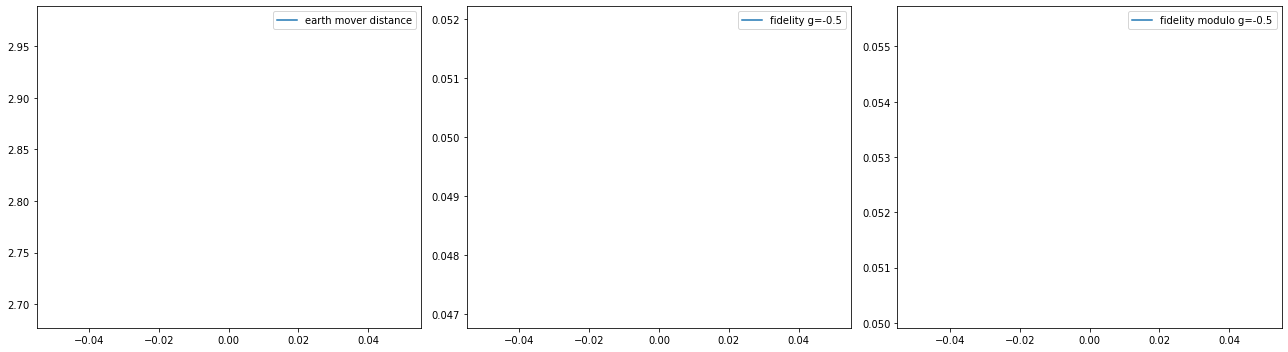

----------------------------------------------------
Epoch 0:  distance = 2.832874891958774
h=Z((0, 1)), w=0.49999999915123094, e=0.9999980926513672
h=Z((0, 0)), w=0.4999999994014377, e=0.9999856948852539
h=Z((0, 3))*Z((0, 4)), w=0.9999999999319322, e=1.3328839540481567
h=Z((0, 1)), w=0.4999999993546697, e=0.9999980926513672
Fidelity for g=-0.5 : 0.04949064022584082
Fidelity modulo for g=-0.5 : 0.05281812194322577


In [ ]:
trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

In [482]:
def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator,
                                    g, 
                                    size):
    generated = gen_evaluator.get_state_from_params(trace_dims=list(range(size)))
    real = real_evaluator.get_state_from_params(g)
    return generated, real, cirq.fidelity(generated, real), cirq.fidelity(abs(generated), abs(real))

In [483]:
gen_evaluator = trainer.gen_evaluator
real_evaluator = trainer.real_evaluator

In [484]:
g = g_values[0]
generated_state, real_state, fidelity, abs_fidelity = get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, g, data_bus_size)

In [485]:
generated_state, real_state, fidelity, abs_fidelity

(array([ 0.1174136 +0.01748485j,  0.17838532+0.01843486j,
         0.12357821+0.04360601j, -0.08263013-0.02545642j,
        -0.08253708+0.02117492j, -0.11917517+0.03427763j,
         0.17506282-0.00713821j, -0.12293534+0.00717992j,
        -0.08557609-0.02785951j, -0.13245133-0.03697325j,
        -0.08781958-0.05008148j,  0.06000928+0.03069575j,
        -0.06947119+0.00688347j, -0.10005232+0.01226939j,
         0.1383224 +0.0187739j , -0.09734631-0.01224019j,
        -0.109216  -0.15177216j, -0.17461604-0.2209194j ,
        -0.08526973-0.18691579j,  0.06071161+0.12074837j,
         0.1136182 +0.06999446j,  0.16897362+0.09662142j,
        -0.19924286-0.18793622j,  0.14250062+0.12898366j,
         0.08450991+0.18216093j,  0.1413903 +0.2736239j ,
         0.05308147+0.22056912j, -0.04259175-0.1456357j ,
         0.11798097+0.10279108j,  0.17280626+0.14483924j,
        -0.18062186-0.25655648j,  0.12844342+0.17983155j], dtype=complex64),
 array([ 0.22222227+0.j,  0.31426978+0.j,  0.22222224